# [Classifying Twitter Sentiments through Supervise Learning ](https://www.kaggle.com/kazanova/sentiment140)

**Introduction**

Twitter is one of the most popular microblogging and social networking platforms for people around the world. This platform lets people communicate and interact via posts (aka "tweets"). Tweets are casual forms of texts and are limited to 140 characters.

Tweets are used by different parties for varied reasons. For instance, consumers use Twitter to research products before purchasing them. Twitter information are used to analyze the customer reviews and sentiments to make a better purchasing distance. Henceforth, sentiment analysis plays a vital part in our everyday life.

For this project, I will use Twitter data to identify the positive and negative sentiments in making a purchasing decision. This will help us identify the patterns on how consumers make their purchasing decisions through sentiments on Twitter.

**Problem Statement:**

The objective of this task is to detect positive sentiments in our dataset. For instance, tweets with a positive sentiment may mean that the customer is satisfied about the product. This information can be used to predict customer spending patterns for the company's future products. It would inherently help us determine revenue for our products. Therefore, my task in this project, is to classify the good(positive) tweets from the bad(negative) ones. 

To start off the following assumptions have already been made during the initial phase of our data collection 
- Ignore neutral tweets 
- The parameters in our tweets are in English
- Ignore emoticons to make the classification processess much simpler

In addition to these assumptions, let us use the following binary terms to classify the our tweets. I believe that this would make our process more simplified:
- **1** indicates a positive tweet
- **0** indicates a negative tweet


In [1]:
# Importing Packages
%matplotlib inline
import sys, os, random
import nltk, re
import time
import tweepy 
import scipy
import string
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob 
from IPython.display import Image
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

# preprocessing and feature extraction
# bag of words scipy.sparse()
from scipy.stats.mstats import winsorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Training the classifier
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline # classifier to make the vectorizer => transformer => classifier easier 
from sklearn.model_selection import train_test_split

# Classifiers for building models
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Evaluation 
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

**Approach**

I will be taking the following steps in analyzing the sentiments in our dataset:

1. Read the Twitter dataset 
2. Initial Exploration
3. Preprocessing and Data Cleaning 
4. Exploratory Analysis and Visualization
4. Feature Extraction 
5. Creating models including Sentiment Analysis
6. Evaluating models

I chose to get a sample of both positive and negative tweets to for this analysis. Since our focus is on the positive tweets, I will pay my emphasis on features that indicate positive sentiments.

Let's dive into the insights of our dataset:

## I. Reading the Twitter Dataset

In [2]:
file_name = "/home/kaneeshadawood/train.csv"

# Loading data from the csv file. 
data = pd.read_csv("/home/kaneeshadawood/train.csv", encoding='latin-1', header=None)
  
# Renaming columns
data.columns = ["sentiment", "user_id", "date", "query", "user", "tweet"] 
data.head(10)

,sentiment,user_id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


**Content**

I named the following columns to get a better understanding of our data fields:

- sentiment: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- user_id: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- query: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- tweet: the text of the tweet (Lyx is cool)

In [3]:
# contents of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment    1600000 non-null int64
user_id      1600000 non-null int64
date         1600000 non-null object
query        1600000 non-null object
user         1600000 non-null object
tweet        1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


The dataset contains 1600000 observations and 6 fields in total. Sentiment and ID are the only numeric fields, whereas the rest are classified into categorical variables.

## II. Initial Data Exploration

Let's now find out the number of positive, negative, and neutral tweets in our data set. For this purpose, I will use pandas .value_counts() method.

In [4]:
count = data['sentiment'].value_counts()
count

4    800000
0    800000
Name: sentiment, dtype: int64

Even though our data set informed us that there is a neutral class (labelled '2'), it is evident that there aren't any neutral tweets. In other words, tweets are split on a 50/50 range, where the trained data have been labelled into negative(0) and postive(4) respectively.

Let's visualize our balanced dataset through a countplot.

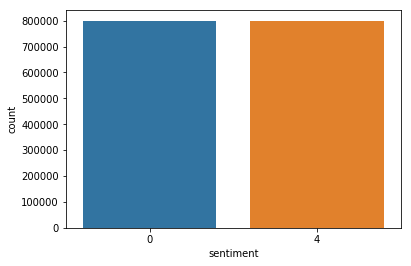

In [5]:
sns.countplot(x='sentiment', data=data)

The data does not indicate any missing values, but let's confirm the following:

In [6]:
total_null = data.isnull().sum().sort_values(ascending=False)
total_null

tweet        0
user         0
query        0
date         0
user_id      0
sentiment    0
dtype: int64

In [7]:
# Finding the unique values in our observations.
data.nunique()

sentiment          2
user_id      1598315
date          774363
query              1
user          659775
tweet        1581466
dtype: int64

There are multiple tweets coming from a wide range of user_ids. User Id's are the unique ID given to each Twitter user. There are more user ids in our dataset that the amount of unique Twitter users. 

Moreover, it is evident that there is only one query in the 'query' column which is 'No_QUERY'. Let's eliminate this column since it adds to no value to our data.

Let's choose a subset of our tweets:

In [8]:
positive_tweet = data[data.sentiment==4].iloc[:200000,:]
print(positive_tweet.shape)
negative_tweet = data[data.sentiment==0].iloc[:200000,:]
print(negative_tweet.shape)

(200000, 6)
(200000, 6)


In [9]:
data = pd.concat([positive_tweet,negative_tweet],axis = 0)
print(data.shape)
data.head()

(400000, 6)


,sentiment,user_id,date,query,user,tweet
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [10]:
# creating a field that indicates the length of our text characters
data['len'] = [len(t) for t in data.tweet]
data.head()

,sentiment,user_id,date,query,user,tweet,len
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,44
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,72
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",137
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,104
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,47


Let's now discover the length of the tweet using a boxplot.

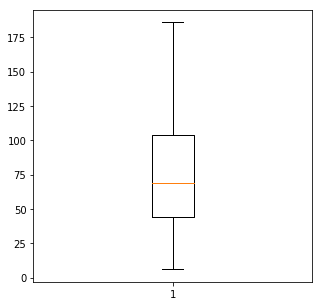

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data['len'])
plt.show()

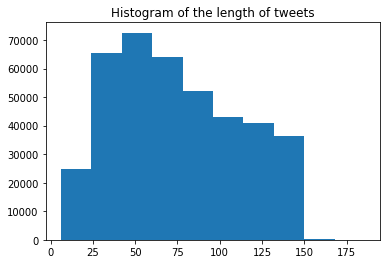

In [12]:
plt.hist(data["len"])
plt.title("Histogram of the length of tweets")
plt.show()

In [13]:
data['len'].mean()

74.216735

The length of the tweets is skewed to the right with the average being 74 characters. 

Let's now detect the outliers despite our distribution. I chose to use the Interquartile Range(IQR) method to detect outliers since not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. The IQR is calculated by taking into account the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

In [14]:
# Calculating the IQR using NumPy's percentile() method 
q75, q25 = np.percentile(data["len"], [75 ,25])
iqr = q75 - q25

# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
outliers = [x for x in data['len'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Identified outliers: 0


Outliers are extreme values that are outside the range of what is expected and unlike the other data. We do not have any outliers in our sample set of data; therefore, we could focus on our new step of clesning the data.

## III. Data Preprocessing and Cleaning

The raw Twitter text include people's casual opinions in the form of informal language. The tweets above include, punctuations, special characters, user mentions etc. We have also identified outliers in our dataset. These features add noise to our data and should be eliminated before we create our model.

Let's now dive into performing the following preprocessing steps before we could build our model. Let us use the following steps to get rid of the noise in our dataset:

- Rename the Postive sentiment as '1'
- Drop columns: 'user_id', 'date', 'query'
- Converting tweets to lower case
- Preprocessing the 'tweet' field
    - Removing punctuations, numbers, repetitions, irrelevant characters
    - Remove Twitter handles, URLs 
    - Eliminate White spaces
- Eliminating outliers
- Identifying stopwords
- Stemming: Transform to the root word
- Lemmatization: Transform words to dictionary base form

**1. Renaming the Positive Sentiment Polarity**

In [15]:
# Casting the positive sentiment to 1
data[data.loc[:, 'sentiment'] == 4] = 1

# Confirming the above code:
print(data['sentiment'].value_counts())

1    200000
0    200000
Name: sentiment, dtype: int64


**2. Dropping columns**

In [16]:
data.drop(['user_id','date','query','user'], axis=1, inplace=True)

I chose to drop the above columns so that we could focus more specifically on classifying our text Twitter data along with our sentiments. Moreover, the field 'query' indicates 'no_query' at all instances which means that this feature in a constant. 

**3. Converting tweets to lower case**

In [17]:
# Converting Tweets to lower case
data['clean_tweet'] = data['tweet'].apply(lambda x: str(x).lower())

**4. Cleaning tweet field**

In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
# Eliminating Puntuations:
def remove_punct(tweet):
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', '', tweet)
    return tweet

data['clean_tweet'] = data['clean_tweet'].apply(lambda x: remove_punct(x))

In [20]:
# Removing Twitter Handles:
data['clean_tweet'] = data['clean_tweet'].str.replace("@[\w]*", " ") 

# Removing URLs
data['clean_tweet'] = data['clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")

# Removing numbers, special characters
data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ") 

# Removing numbers
data['clean_tweet'] = data['clean_tweet'].str.replace('\d+', '')

# Removing whitespaces
data['clean_tweet'] = data['clean_tweet'].str.strip()

# Removing Single characters
data['clean_tweet'] = data['clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")

**5. Tokenization and Normalization**

In [21]:
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: x.split())

In [22]:
data.tail()

,sentiment,tweet,len,clean_tweet
199995,0,Doesn't feel good.,19,"[doesnt, feel, good]"
199996,0,work... again,14,"[work, again]"
199997,0,@damienfranco Its so common for it to crash no...,133,"[damienfranco, its, so, common, for, it, to, c..."
199998,0,my baby boy is wearing big boy underwear,41,"[my, baby, boy, is, wearing, big, boy, underwear]"
199999,0,Fml! I forgot my phone charger @home!,38,"[fml, forgot, my, phone, charger, home]"


**6. Dealing with Stop Words**

In [23]:
# Removing Stopwords
nltk.download('stopwords')

# Here is a list of the stopwords identified by NLTK.

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaneeshadawood/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Removing stop words

from nltk.corpus import stopwords
stop = stopwords.words("english")                

data['clean_tweet'] = data['clean_tweet'].apply(lambda x: [word for word in x if word not in stop])

In [25]:
# Expanding the tweet
# Function to expand tweet
def expand_tweet(tweet):
        expanded_tweet = []
        for word in tweet:
            if re.search("n't", word):
                expanded_tweet.append(word.split("n't")[0])
                expanded_tweet.append("not")
            else:
                expanded_tweet.append(word)
        return expanded_tweet

data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: expand_tweet(tweet))

**6. Lemmatizing**

In [26]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/kaneeshadawood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer

lemma = nltk.WordNetLemmatizer()

data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: [lemma.lemmatize(word) for word in tweet])

In [28]:
# combining words to tweets 
data['clean_tweet'] = data['clean_tweet'].apply(lambda tweet: ' '.join(tweet)) 

In [29]:
data.tail()

,sentiment,tweet,len,clean_tweet
199995,0,Doesn't feel good.,19,doesnt feel good
199996,0,work... again,14,work
199997,0,@damienfranco Its so common for it to crash no...,133,damienfranco common crash find delete process ...
199998,0,my baby boy is wearing big boy underwear,41,baby boy wearing big boy underwear
199999,0,Fml! I forgot my phone charger @home!,38,fml forgot phone charger home


In [30]:
# Removing Small words
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data.tail()

,sentiment,tweet,len,clean_tweet
199995,0,Doesn't feel good.,19,doesnt feel good
199996,0,work... again,14,work
199997,0,@damienfranco Its so common for it to crash no...,133,damienfranco common crash find delete process ...
199998,0,my baby boy is wearing big boy underwear,41,baby wearing underwear
199999,0,Fml! I forgot my phone charger @home!,38,forgot phone charger home


Let's save our clean data to a csv file.

In [33]:
df = pd.DataFrame(data)

df.to_csv('clean_data.csv', index=False)

## IV. Exploratory Analysis

Now that we our data is preprocessed, let's explore the text one more time to identify the most important features. This will help us understand the most important features we need to build our model.

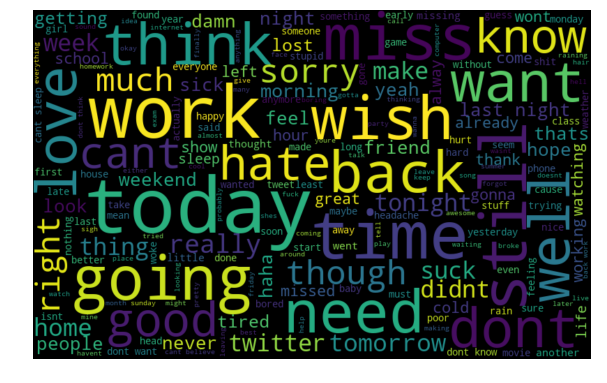

In [31]:
# Visualizing our processed data:

from wordcloud import WordCloud

# Generate a word cloud image
all_words = ' '.join([text for text in data['clean_tweet']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

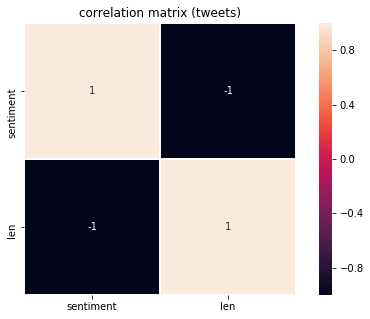

In [35]:
# checking correlation between length of words and positive sentiments

# make the correlation matrices.
data = data.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(data, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (tweets)")

plt.show()


**What are the most common Positive Words?**

In [38]:
positive_words =' '.join([text for text in data['clean_tweet'][data['sentiment'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

KeyError: 'clean_tweet'

## IV. Feature Extraction

Let's find the positive words in our cleaned data:

Let's extract more features through Bag of Words and TF-IDF Feature extraction. I believe that this would help us identify the most unique features to build our models.

**Bag of Words**

Bag-of-Words is a method to represent text into numerical features.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(data['clean_tweet'])

KeyError: 'clean_tweet'

**TF-IDF Features**

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(data['clean_tweet'])

## V. Modelling

Before, we build our model let's split our dataset into two sets on a 80:20 split

In [39]:
train = bow[:400000,:]
test  = bow[100000:,:]

# splitting data into training and validation set
X_train, X_test, y_train,y_test = train_test_split(bow ,data['sentiment'], test_size=.2,stratify=data['sentiment'], random_state=42)

NameError: name 'bow' is not defined

In [ ]:

X_train,X_test,y_train,y_test = train_test_split(cv,data['target'] , test_size=.2,stratify=data['target'], random_state=42)

**OLS Regression Model**

In [46]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

cross_val_score(yvalid, prediction_int) # calculating f1 score

ValueError: Found input variables with inconsistent numbers of samples: [31962, 500000]

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
prediction_lr = lr.predict(X_test)
print(accuracy_score(prediction_lr,y_test))

**Random Forest Model**

In [48]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train,y_train)
prediction_rf = rf.predict(X_test)
print(accuracy_score(prediction_rf,y_test))

KeyboardInterrupt: 

**Naive Bayes**

In [33]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], tfidf.iloc[:, 0],
                                                    train_size=0.7, stratify=tfidf.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, cross_val_score = test_classifier(X_train, y_train, X_test, y_test, MultinomialNB())

AttributeError: iloc not found

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

bnb = BernoulliNB()
y_pred = bnb.fit(X_train, y_train).predict(X_test)
print(cross_val_score(ml, X_train, y_train, cv=10))
print(accuracy_score(y_pred,y_test))

**SVM**

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train,y_train)
prediction_svc = svc.predict(X_test)
print(accuracy_score(prediction_svc,y_test))

## VI. Evaluation

In [ ]:
4. Random Forest

## Resources:

- [The dataset](https://www.kaggle.com/kazanova/sentiment140)
- [Scikit-learn machine learning libararies](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- [Natural Language Toolkit](https://www.nltk.org/)